# Model Interpretation - Part 2
## Model interpretation, with SHAP

Model interpretation, with SHAP

[SHAP (SHapley Additive exPlanations)](https://github.com/shap/shap) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions (see papers for details and citations).

@Ricardo Almeida

In [41]:
# Additional requirements
# conda xgboost

In [42]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import graphviz
import xgboost

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [43]:
import shap

In [44]:
shap.initjs()

In [45]:
RANDOM_SEED = 7657

TEST_SIZE=0.20

In [46]:
def plot_history(train_hist):
    pd.DataFrame(train_hist).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
    plt.show()

## Breast cancer wisconsin (diagnostic) dataset

#### Loading dataset

In [47]:
dataset = load_breast_cancer()

In [48]:
print(dataset.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [49]:
dataset.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [50]:
dataset.target_names

array(['malignant', 'benign'], dtype='<U9')

In [51]:
dataset.data = dataset.data[:, :10]

In [52]:
dataset.feature_names = dataset.feature_names[:10]
dataset.feature_names = [f.removeprefix('mean ') for f in dataset.feature_names]

In [53]:
for f in dataset.feature_names:
    print(f"'{f}'")

'radius'
'texture'
'perimeter'
'area'
'smoothness'
'compactness'
'concavity'
'concave points'
'symmetry'
'fractal dimension'


In [54]:
# Standardize the features
data_scaled = StandardScaler().fit_transform(dataset.data)

In [55]:
X_train, X_dev, y_train, y_dev = train_test_split(
    data_scaled, dataset.target, random_state=RANDOM_SEED, test_size=TEST_SIZE)

#### Tree model

In [56]:
MAX_DEPTH = 3
MIN_SAMPLES_LEAF = 5
MIN_SAMPLE_SPLIT = 10

Fit the model

In [57]:
clf = DecisionTreeClassifier(random_state=RANDOM_SEED,
                             max_depth=MAX_DEPTH,
                             min_samples_leaf=MIN_SAMPLES_LEAF,
                             min_samples_split=MIN_SAMPLE_SPLIT)

model = clf.fit(X_train, y_train)

Check performance

In [58]:
print("Accuracy on train set:  {:.1f}%".format(model.score(X_train, y_train)*100))
print("Accuracy on test  set:  {:.1f}%".format(model.score(X_dev, y_dev)*100))

Accuracy on train set:  95.6%
Accuracy on test  set:  93.0%


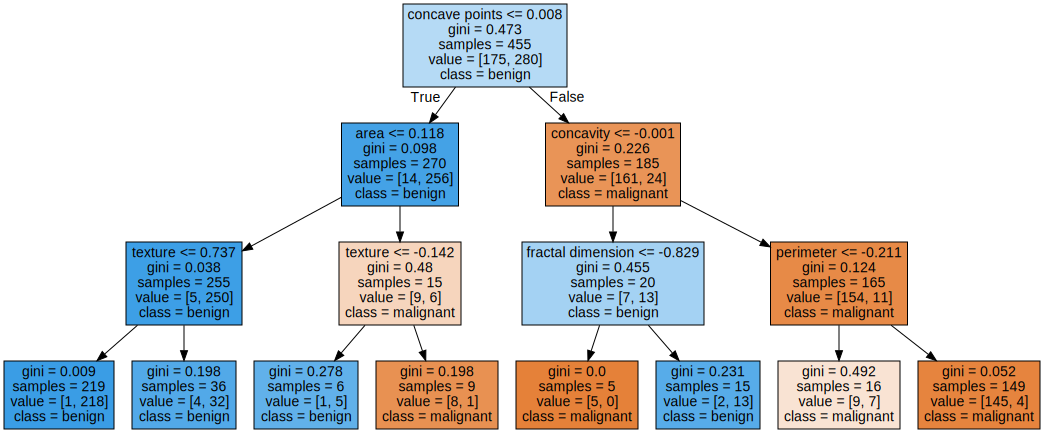

In [59]:
dot_data = export_graphviz(model, out_file=None, 
                                feature_names=dataset.feature_names,  
                                class_names=dataset.target_names,
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png")
graph

In [60]:
# Get feature importances from the trained classifier
feature_importances = model.feature_importances_

In [61]:
importance_df = pd.DataFrame({'Feature': dataset.feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance for better visualization
importance_df = importance_df.sort_values(by='Importance', ascending=False)

In [62]:
importance_df

,Feature,Importance
7,concave points,0.800514
6,concavity,0.066080
3,area,0.051952
9,fractal dimension,0.030664
2,perimeter,0.026526
1,texture,0.024264
0,radius,0.000000
4,smoothness,0.000000
5,compactness,0.000000
8,symmetry,0.000000


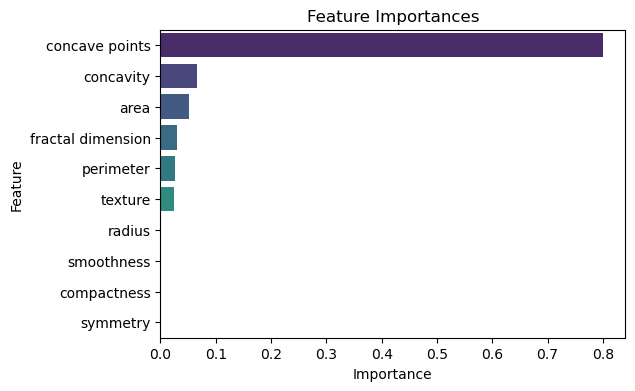

In [63]:
# Plot the horizontal bar chart using Seaborn
plt.figure(figsize=(6, 4))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importances')
plt.show()

#### XGBoost model

Fit the model

In [64]:
X_train = pd.DataFrame(X_train, columns=dataset.feature_names)

In [65]:
model = xgboost.XGBRegressor().fit(X_train, y_train)

In [66]:
X_train

,radius,texture,perimeter,area,smoothness,compactness,concavity,concave points,symmetry,fractal dimension
0,1.540126,2.206141,1.714788,1.570260,-0.267602,1.932274,1.124934,1.689012,0.297119,-0.067706
1,-0.252003,0.195555,-0.210030,-0.318509,-0.962177,0.340350,0.153179,-0.531076,-0.768957,0.215815
2,-0.970559,0.256059,-0.925504,-0.881641,0.842579,0.465430,-0.054229,-0.522306,-0.524343,0.825384
3,-0.334368,-0.760869,-0.363670,-0.401556,0.294605,-0.472100,-0.342114,-0.392562,-0.297985,0.269684
4,0.083133,-0.639862,0.089834,-0.038933,0.081820,0.181157,-0.109596,-0.172540,0.366487,0.187463
...,...,...,...,...,...,...,...,...,...,...
450,0.046211,-0.574704,-0.068748,-0.063392,-2.282296,-1.470464,-1.023849,-1.100607,-1.108494,-1.281175
451,0.137096,-0.837662,0.029285,0.028472,-1.436139,-1.311272,-0.933202,-0.777667,-0.655777,-1.452705
452,-0.553058,-0.337343,-0.584037,-0.579597,0.579267,-0.640010,-0.802254,-0.503219,0.322675,0.503588
453,0.219460,0.754052,0.417297,0.085638,0.221305,2.239288,2.316401,1.243034,0.837458,0.876418


In [67]:
# Create the explainer
explainer = shap.TreeExplainer(model)

shap_values = explainer(X_train)

In [68]:
shap_values.shape

(455, 10)

#### Single instance interpretation

In [72]:
SAMPLE_INDEX = 33

In [73]:
# visualize with a force plot
shap.plots.force(shap_values[SAMPLE_INDEX])

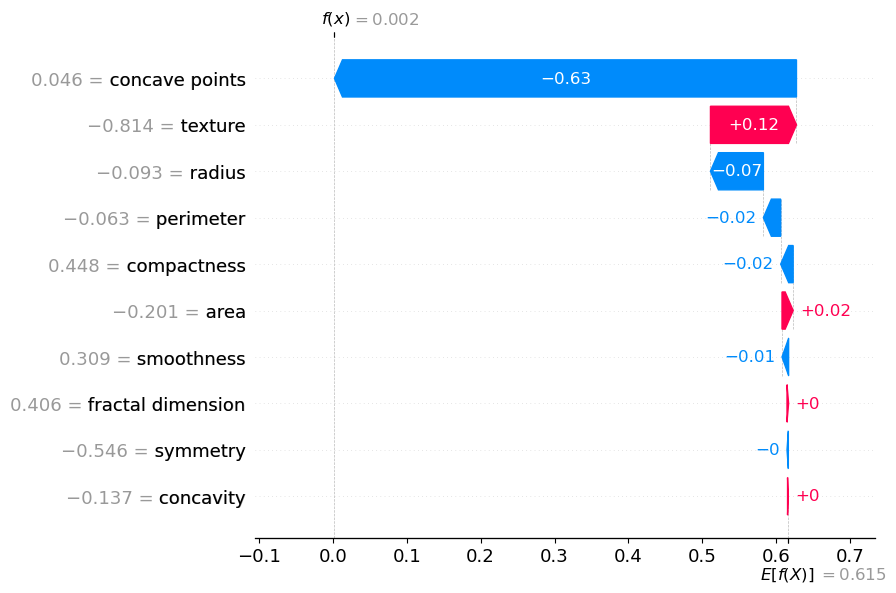

In [74]:
# visualize a single prediction's explanation

shap.plots.waterfall(shap_values[SAMPLE_INDEX])

#### Global interpretation

summarize the effects of all the features

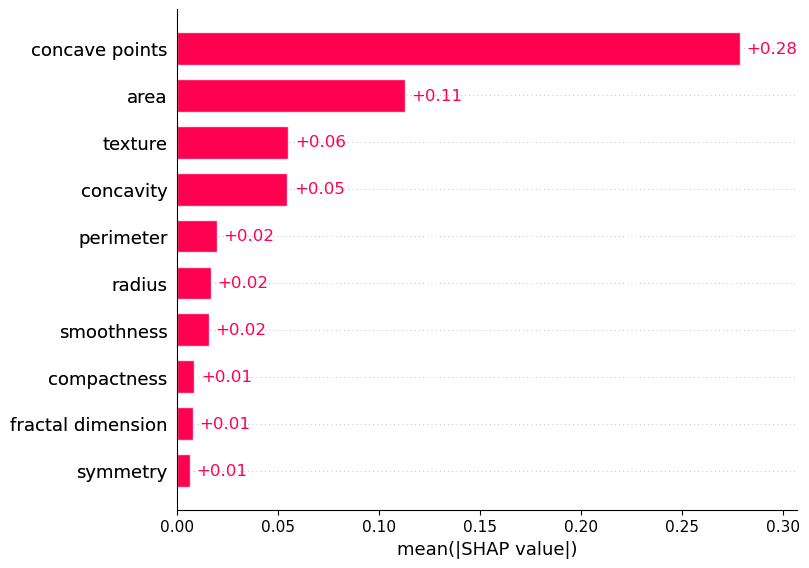

In [30]:
shap.plots.bar(shap_values)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


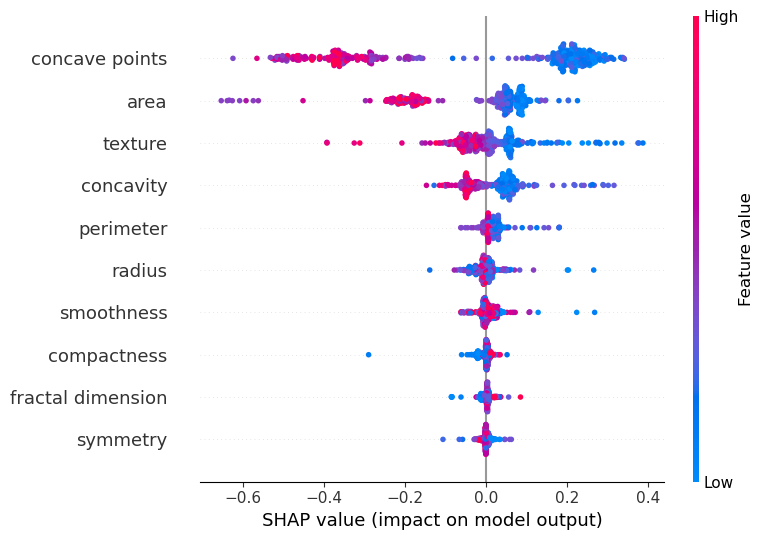

In [31]:
# = shap.plots.beeswarm(shap_values)
shap.summary_plot(shap_values)

#### Other example

In [32]:
# train an XGBoost model
X, y = shap.datasets.california()
model = xgboost.XGBRegressor().fit(X, y)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X)

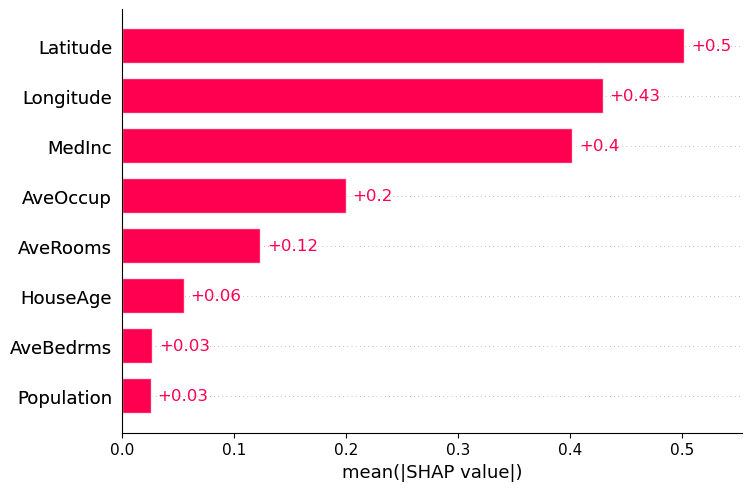

In [34]:
shap.plots.bar(shap_values)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


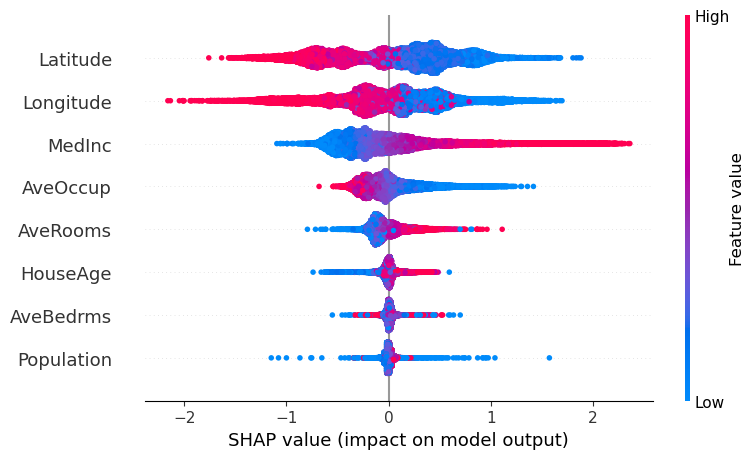

In [35]:
shap.summary_plot(shap_values)

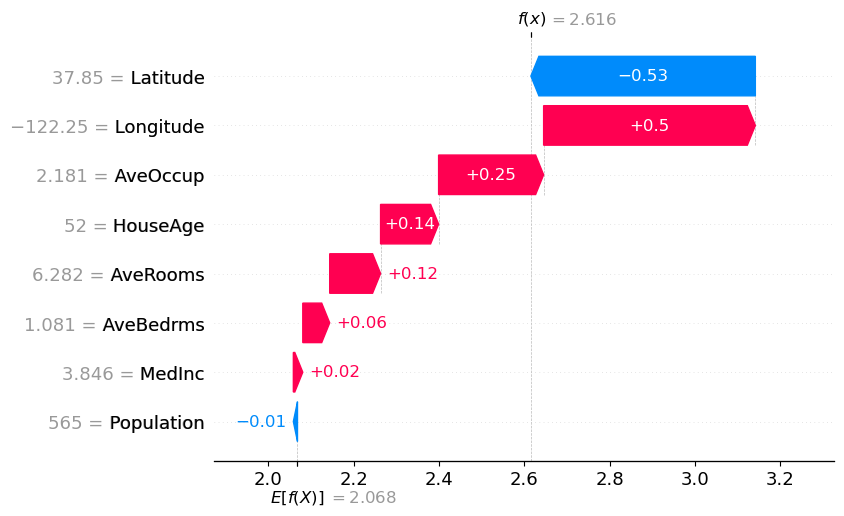

In [33]:
# visualize a single prediction's explanation
shap.plots.waterfall(shap_values[4])